# Bringing the Data Scientist Up to Speed With MerLin

This notebook is destined for new users that have a data science or machine learning background that want to upgrade their MerLin experience. In other words, people that just started exploring MerLin with the ``QuantumLayer.simple()`` method and want a little more expressivity and control on their ``QuantumLayer``. Here is a notebook explaining step by step how to use the powerful CircuitBuilder to create more powerful and expressive quantum models.


MerLins's QuantumLayer offers much more flexibility that what the ``simple()`` method's is offering. Indeed,
it is possible to adapt the interferometer of the layer to our desires easily with the CircuitBuilder.

Run the following imports.

In [ ]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import perceval as pcvl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_digits, load_iris,make_moons
from sklearn.model_selection import train_test_split

import merlin as ML

torch.manual_seed(0)
np.random.seed(0)

## ``simple()`` recap: classifying iris

The ``simple()`` method can be usefull for small classification tasks. Here, we can use it to classify the famous Iris dataset which has 4 features and three flower types.

Let's first load the data.

In [ ]:
iris = load_iris()
X = iris.data.astype("float32")
y = iris.target.astype("int64")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True).clamp_min(1e-6)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Train size: 112 samples
Test size: 38 samples


We can then easily create a quantum layer with the ``simple()``method.

In [ ]:
quantum_classifier = ML.QuantumLayer.simple(input_size=4, output_size=3)

quantum_classifier

SimpleSequential(
  (quantum_layer): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (post_processing): ModGrouping()
)

We can use this layer as ``torch.Module`` to classify the dataset.

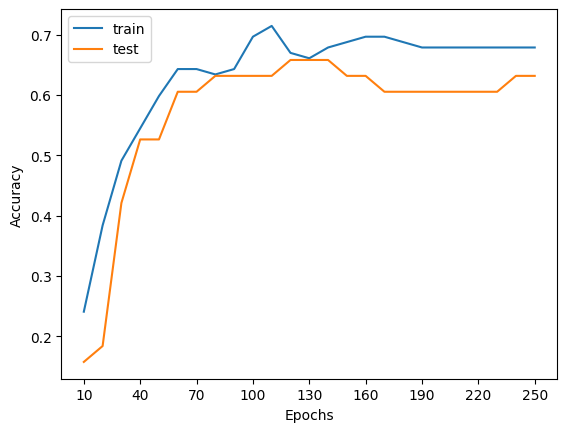

In [ ]:
test_accs, train_accs = [[], [], []], [[], [], []]
epochs = [25 * i for i in range(1, 10)]
photon_counts = [1, 2, 3]

for i, num_photons in enumerate(photon_counts):
    for epoch in epochs:
        qcirc = ML.QuantumLayer(builder=deepcopy(circuit), n_photons=num_photons)
        quantum_classifier = nn.Sequential(qcirc, ML.ModGrouping(qcirc.output_size, 10))

        losses, train_acc, test_acc = run_experiment(quantum_classifier, epochs=epoch, lr=0.01)
        test_accs[i].append(test_acc)
        train_accs[i].append(train_acc)

for i, num_photons in enumerate(photon_counts):
    plt.plot(epochs, train_accs[i], label=f"train (photons={num_photons})")
    plt.plot(epochs, test_accs[i], linestyle='--', label=f"test (photons={num_photons})")

ticks = epochs.copy()
indexes_to_pop = []
index = 0
for i in range(len(epochs)):
    if i % 3 > 0:
        ticks.pop(index)
    else:
        index += 1

plt.xticks(ticks=ticks, labels=[str(p) for p in ticks])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## What is ``simple()`` doing?

The simple method creates an interferometer from the same template every time. Indeed, the circuit that is created has the same number of modes as the number of features and puts a photon every two modes. There is exactly one feature encoded per mode. Here is an example of the circuit for an input size (number of features) of 10.

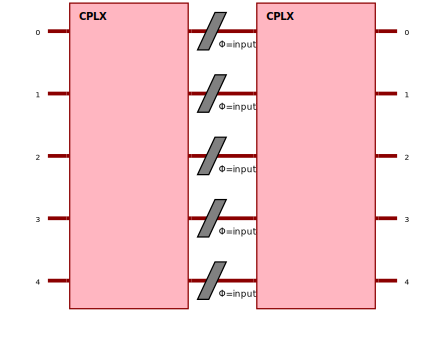

In [ ]:
qlayer=ML.QuantumLayer.simple(input_size=5,output_size=4)

pcvl.pdisplay(qlayer.circuit)

We are limited quickly by computation capabilities as well as photon-number control.

## When does ``simple()`` becomes not appropriate?

The use of the ``simple()`` method is perfect for beginners in photonic QML who just want to explore the quantum capabilities on easy and small datasets. However, we will need to use the full power of the QuamtumLayer to classify more complex and usefull datasets. Indeed, the method only works for datasets that have 20 or less features due to simulation speed reasons. Also, as stated in the [Fock State-enhanced Expressivity of Quantum Machine Learning Models](https://arxiv.org/abs/2107.05224) paper by Gan *et al*, the expressivity of a photonic quantum layer is directly related to the number of photons. The ``simple()`` method does not allow the user to change in input state of the interferometer.

We will present another easy to use tool to add a QuantumLayer to your torch modules that lets you control the input photons without any feature restrictions.

## Transition to ``merlin.CircuitBuilder``

Lets introduce MerLin's powerful ``CircuitBuilder``. This object can be directly passed to a quantum layer. For a specified number of modes, we can create many interferometer patterns. Lets go deeper to the available patterns.

First, lets create an instance of this object.

In [ ]:
circuit_builder = ML.CircuitBuilder(n_modes=2)

circuit_builder

### A) ``add_rotations()``

If we want to add simple rotations on given modes, we can use the ``add_rotations()`` method. We can make the parameters trainable and define the starting angle if necessary. 

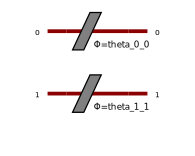

In [ ]:
circuit_builder.add_rotations(modes=[0, 1], trainable=True, angle=0.36)

pcvl.pdisplay(circuit_builder.to_pcvl_circuit())

### B) ``add_superposition()``

If we want to add a simple interaction on given modes, we can use the ``add_superposition()`` method. We can make the parameters trainable, define the starting angles if necessary. 

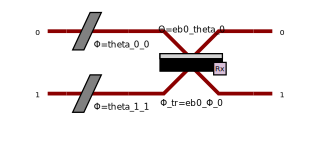

In [ ]:
circuit_builder.add_superpositions(modes=[0, 1], theta=0.1, phi=0.15, trainable=True)

pcvl.pdisplay(circuit_builder.to_pcvl_circuit())

### C) ``add_entangling_layer()``

If we want a more complex interactions between the modes, we can add an entangling layer. This layer can represent every single interactions between the modes. The parameters can also be trainable. There are two patterns being "mzi" and "bell". Here we will use the default one being "mzi".

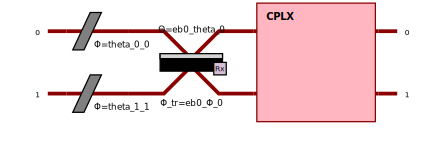

In [ ]:
circuit_builder.add_entangling_layer(modes=[0, 1], trainable=True, model="mzi")

pcvl.pdisplay(circuit_builder.to_pcvl_circuit())

### Encoding

Just as simple does, we can add angle encoding to the interferometer. It is how and where the features will be assigned in the boson sampler on a forward pass. It is easy to add with a simple call of the ``add_angle_encoding()`` method.

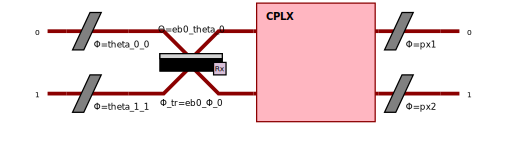

In [ ]:
circuit_builder.add_angle_encoding(modes=[0, 1])

pcvl.pdisplay(circuit_builder.to_pcvl_circuit())

## Create a ``QuantumLayer`` from the ``CircuitBuilder``

### Changing the number of photons
With circuit builder we can now specify the number of photons or the input state of the circuit. Here we will explore the relation between expressivity and the number of photons by classifying the ``make_moons`` dataset. It is a dataset with 2 features and 2 classes.

Lets's first load the dataset

In [7]:
digits = make_moons(n_samples=250)
X = digits[0]
y = digits[1]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True).clamp_min(1e-6)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Train size: 187 samples
Test size: 63 samples


Lets create a 3 mode interferometer with the circuit builder.

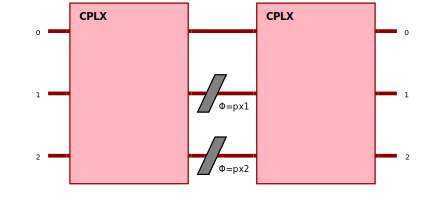

In [8]:
circuit = ML.CircuitBuilder(n_modes=3)

circuit.add_entangling_layer()
circuit.add_angle_encoding(modes=[1,2])
circuit.add_entangling_layer()

pcvl.pdisplay(circuit.to_pcvl_circuit())

Lets run the classification experiment.

In [9]:
# A simple training experiment
def run_experiment(layer: torch.nn.Module, epochs: int = 60, lr: float = 0.05):
    optimizer = torch.optim.Adam(layer.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        layer.train()
        optimizer.zero_grad()
        logits = layer(X_train)
        loss = F.cross_entropy(logits, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    layer.eval()
    with torch.no_grad():
        train_preds = layer(X_train).argmax(dim=1)
        test_preds = layer(X_test).argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()
        test_acc = (test_preds == y_test).float().mean().item()
    return losses, train_acc, test_acc

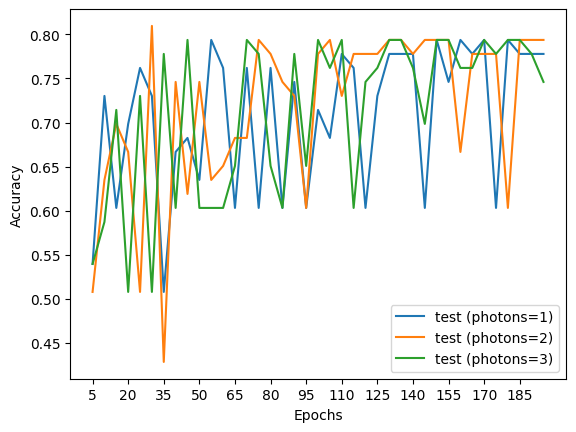

In [13]:
test_accs = [[],[],[],[],[]]
epochs = [5 * i for i in range(1, 40)]
for i,num_photons in enumerate([1,2,3]):
    for epoch in epochs:
        qcirc = ML.QuantumLayer(builder=deepcopy(circuit), n_photons=1)
        quantum_classifier = nn.Sequential(qcirc, ML.ModGrouping(qcirc.output_size, 2))

        losses, train_acc, test_acc = run_experiment(quantum_classifier, epochs=epoch, lr=0.01)
        test_accs[i].append(test_acc)


# Plotting function
for i, num_photons in enumerate([1,2,3]):
    plt.plot(epochs, test_accs[i], label=f"test (photons={num_photons})")

ticks = epochs.copy()
index = 0
for i in range(len(epochs)):
    if i % 3 > 0:
        ticks.pop(index)
    else:
        index += 1

plt.xticks(ticks=ticks, labels=[str(p) for p in ticks])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We see that the more the photons, we get more stable runs as the number of epochs increases, showing the control of number of photons, increase expressivity and stability over runs.


### How to encode more features than modes.

To test the new way of using a QuantumLayer, we will try to classify ``scikit.learn``'s ``load_digits`` dataset. It is composed of 8x8 images of hand-written numbers 0 through 9. So, it has 64 features per image, much more than ``simple()`` can handle. It is still an easy dataset to classify in theory.

Let's load the dataset

In [ ]:
digits = load_digits()
X = digits.data.astype("float32")
y = digits.target.astype("int64")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True).clamp_min(1e-6)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Train size: 1347 samples
Test size: 450 samples


Let's create a circuit with 8 modes and 8 angle encoding layers.

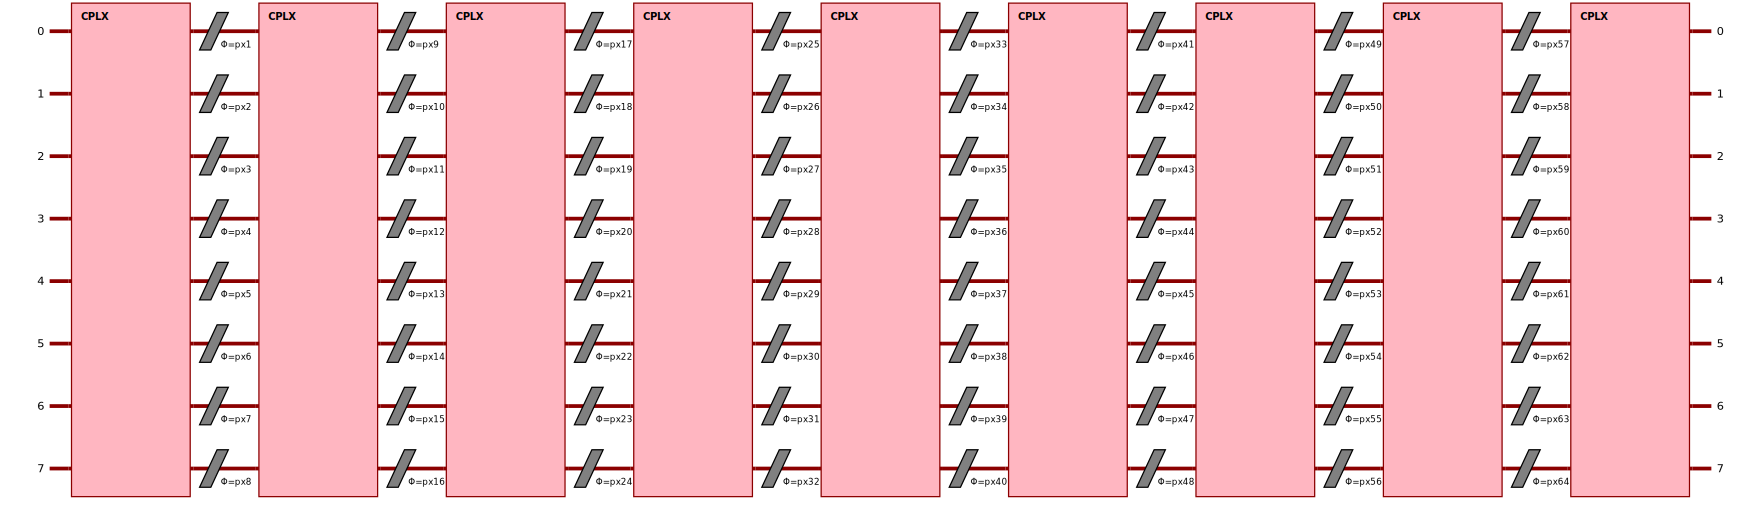

In [ ]:
circuit = ML.CircuitBuilder(n_modes=8)

circuit.add_entangling_layer()
for _ in range(8):
    circuit.add_angle_encoding()
    circuit.add_entangling_layer()

pcvl.pdisplay(circuit.to_pcvl_circuit())

Lets run the classification experiment

In [ ]:
# A simple training experiment
def run_experiment(layer: torch.nn.Module, epochs: int = 60, lr: float = 0.05):
    optimizer = torch.optim.Adam(layer.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        layer.train()
        optimizer.zero_grad()
        logits = layer(X_train)
        loss = F.cross_entropy(logits, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    layer.eval()
    with torch.no_grad():
        train_preds = layer(X_train).argmax(dim=1)
        test_preds = layer(X_test).argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()
        test_acc = (test_preds == y_test).float().mean().item()
    return losses, train_acc, test_acc

To give the right output size, we will use a ``ML.ModGrouping``strategy to make sure was have an output dimension of 10. It combines the outputs of the quantum circuit in a dimension 10 vector (one dimension per class).

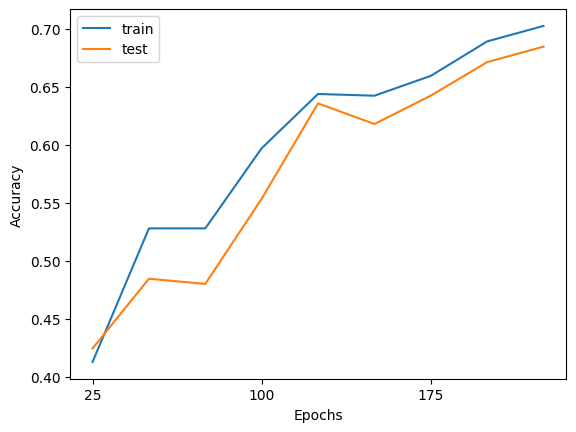

In [ ]:
# Running the experiment
test_accs, train_accs = [], []
epochs = [25 * i for i in range(1, 10)]
for epoch in epochs:
    qcirc = ML.QuantumLayer(builder=deepcopy(circuit), n_photons=1)
    quantum_classifier = nn.Sequential(qcirc, ML.ModGrouping(qcirc.output_size, 10))

    losses, train_acc, test_acc = run_experiment(quantum_classifier, epochs=epoch, lr=0.01)
    test_accs.append(test_acc)
    train_accs.append(train_acc)

# Plotting function
plt.plot(epochs, train_accs, label="train")
plt.plot(epochs, test_accs, label="test")
ticks = epochs
indexes_to_pop = []
index = 0
for i in range(len(epochs)):
    if i % 3 > 0:
        ticks.pop(index)
    else:
        index += 1

plt.xticks(ticks=ticks, labels=[str(p) for p in ticks])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We observe that with 8 times less modes that ``simple()`` would need, we are still able to classify the dataset.

Here you go! You are now ready to take advantage of the full power of MerLin's ``QuantumLayer``! The next step in your journey would be to investigate the different data encoding in the quantum circuits which can be found on the [angle amplitude encoding page](../user_guide/angle_amplitude_encoding.rst).